Lab 5b

I)

1. Modified daisy world's equations and new integrator
$$ \frac{dA_i}{dt}=A_i(x\beta_i-\chi_d),i=b,w$$
$$ \frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r-\chi_r-\chi_{featr}]$$
$$ \frac{dA_f}{dt}=A_f[A_r\beta_f-\chi_f]$$
$A_b,A_w,A_r,A_f$ are the fractional coverage of black daisy, white daisy, rabbit, and fox respectively.
$\beta_r$ is a constant related to the growth rate of rabbit. I assume it's a constant.
$\beta_f$ is a constant related to the growth rate of fox. I assume it's a constant.
$\chi_f$ is the death rate of fox. I assume it's a constant.
$$ x=1-A_b-A_w-A_r-A_f$$
$$\chi_d=\chi_{c1}A_r$$
$$\chi_{featr}=\chi_{c2}A_f$$
$\chi_{c1}$,$\chi_{c2}$,$\chi_r$ and $\chi_f$ are constants.
$$\alpha_p=A_b\alpha_b+A_w\alpha_w+A_r\alpha_r+A_f\alpha_f+x\alpha_g$$
$$T^4_e=\frac{S_0L}{4\sigma}(1-\alpha_p)$$
$$T^4_i=L\frac{RS_0}{4\sigma}(\alpha_p-\alpha_i)+T^4_e$$
$$\beta_i=1-0.003265(295.5K-T_i)^2$$
i=b,w,except r(rabbit) and f(fox)


In [52]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class Integpredator(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc,self.initvars.rabbitconc,self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [4] with the white [0], black [1], rabbit [2], and fox[3]
                    creature fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1] - yvals[2] - yvals[3]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black + yvals[2] * user.albedo_rabbit + yvals[3] * user.albedo_fox
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.S0 / (4.0 * sigma)
        temp_b = (eta * user.L * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * user.L * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction rabbit
           y[3]=fraction fox
           temperature does not influence growth rates and death rates of both rabbit and fox
        """
        temp_w, temp_b,  temp_e = self.find_temp(y)

        if(temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if(temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1] - y[2] - y[3]
        # create a 1 x 4 element vector to hold the derivitive
        f = np.empty_like(y)
        if y[2]<0:
            y[2]=0
        if y[3]<0:
            y[3]=0
        f[0] = y[0] * (beta_w * bare - y[2] * user.chi_c1)
        f[1] = y[1] * (beta_b * bare - y[2] * user.chi_c1)
        f[2] = y[2]*((y[0] + y[1]) * user.beta_r - y[3] * user.chi_c2 - user.chi_r)
        f[3] = y[3] * (y[2] * user.beta_f - user.chi_f)
        return f

2.Choose a set of parameters and run

Parameters:
$$ \alpha_w = 0.75 $$
$$ S0=3668.0 $$
$$ L=1.1 $$
$$ \alpha_b=0.25 $$
$$ R=0.12 $$
$$ \sigma=5.67e-08 $$
$$ \alpha_g = 0.5$$
$$ \alpha_r = 0.5$$
$$ \alpha_f = 0.5$$
$$ \chi_{c1}= 0.2 $$
$$ \chi_{c2}= 0.9 $$
$$ \chi_f = 0.06 $$
$$ \chi_r = 0.06 $$
$$ \beta_f = 0.2 $$
$$ \beta_r = 0.25 $$
Initial conditions:
whiteconc = 0.4, blackconc = 0.3, rabbitconc = 0.1, foxconc = 0.1

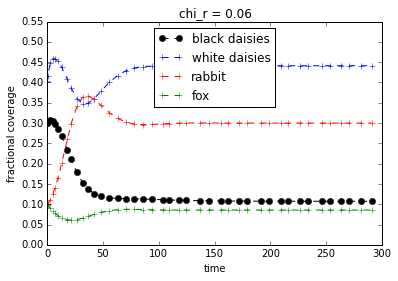

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

theSolver=Integpredator('newfox.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit','fox'])

thefig,theAx=plt.subplots(1,1)


theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['white'],'--b+',label='white daisies')
theLine3,=theAx.plot(timeVals,yvals['rabbit'],'--r+',label='rabbit')
theLine4,=theAx.plot(timeVals,yvals['fox'],'--g+',label='fox')
theAx.set_title('chi_r = 0.06')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
theAx.set_yticks(np.linspace(0,0.55,12))
out=out=theAx.legend(loc='upper center')

3.Choose a few sets of parameters and run

1)Change $\beta_f$ and keep other parameters unchanged.

①$\beta_f = 0.3$

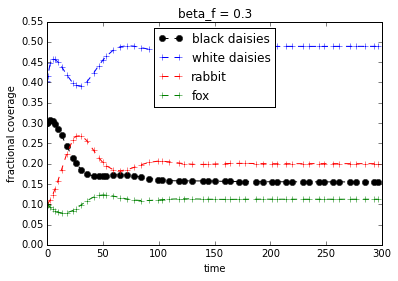

In [33]:
from IPython.display import Image
Image(filename='newfox/beta_f_3.png') 

②$\beta_f = 0.2$

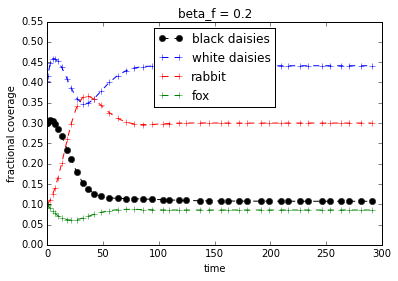

In [34]:
from IPython.display import Image
Image(filename='newfox/beta_f_2.png') 

③$\beta_f = 0.1$

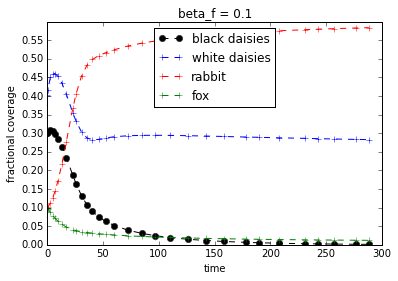

In [37]:
from IPython.display import Image
Image(filename='newfox/beta_f_1.png') 

Observing the three plots above, we can find that: when $\beta_f$ (the fox's growth rate) decreases, there will be more rabbit. But there will be less fox and daisy.

Explanation:

When $\beta_f$ (fox's growth rate) decreases,the coverage of rabbit will increase due to less predator (or according to $\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0$). Because of the increase of rabbit, there will less white daisy and black daisy. Then according to $\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r - \chi_r-A_f\chi_{c2}] = 0$, $A_f = \frac{(A_b+Aw)\beta_r -\chi_r}{\chi_{c2}}$ will decrease.

2)Change $\chi_f$ and keep other parameters unchanged.

①$\chi_f = 0.08$

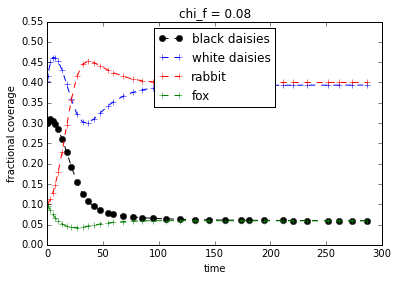

In [38]:
from IPython.display import Image
Image(filename='newfox/chi_f_8.png') 

②$\chi_f = 0.06$

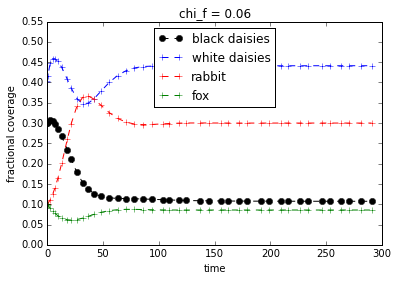

In [39]:
from IPython.display import Image
Image(filename='newfox/chi_f_6.png') 

③$\chi_f = 0.04$

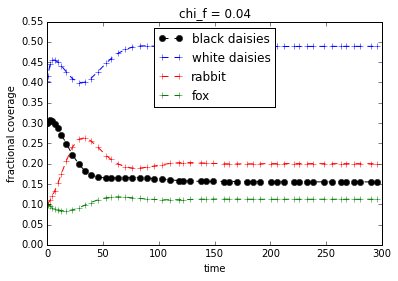

In [40]:
from IPython.display import Image
Image(filename='newfox/chi_f_4.png') 

Observing the three plots above, we can find that: when $\chi_f$ (the fox's death rate) decreases, there will be less rabbit. But there will be more fox and daisy.

Explanation:

When $\chi_f$ (fox's death rate) decreases,the converage of rabbit will decrease ($\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0$). Then there will be more black and white daisy. According to $\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r - \chi_r - A_f\chi_{c2}] = 0$, $A_f = \frac{(A_b+Aw)\beta_r -\chi_r}{\chi_{c2}}$ will increase.

3)Change $\chi_{c1}$ and keep other parameters unchanged.

①$\chi_{c1} = 0.3$

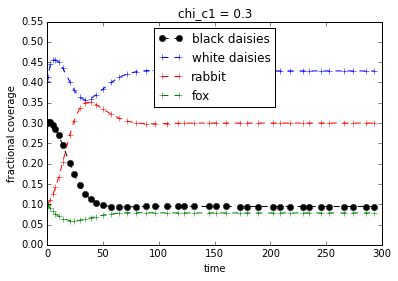

In [41]:
from IPython.display import Image
Image(filename='newfox/chi_c1_3.png') 

②$\chi_{c1} = 0.2$

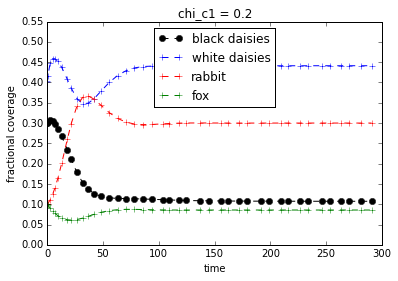

In [42]:
from IPython.display import Image
Image(filename='newfox/chi_c1_2.png') 

③$\chi_{c1} = 0.1$

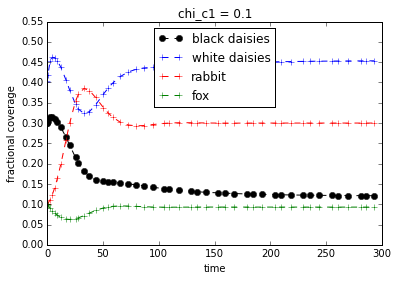

In [43]:
from IPython.display import Image
Image(filename='newfox/chi_c1_1.png') 

Observing three plots above, we can find that: when $\chi_{c1}$ (a constant relatd to daisy's death rate) decreases,the coverage of rabbit will not change, but the coverages of both kind of daisy will increase and that of fox will  also increase.

Explanation:

Because the coverage of rabbit is completely decided by $\chi_f$ and  $\beta_f$ ($\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0)$, when these two parameters do not change, the final coverage of rabbit will no change. When $\chi_{c1}$ (a constant related to the death rate of daisy) decreases, there will be more black and white daisy.  According to $\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r - \chi_r - A_f\chi_{c2}] = 0$, $A_f = \frac{(A_b+Aw)\beta_r - \chi_r}{\chi_{c2}}$ will increase.

4)Change $\chi_{c2}$ and keep other parameters unchanged.

①$\chi_{c2} = 0.9$

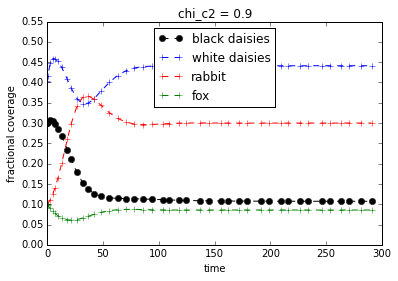

In [44]:
from IPython.display import Image
Image(filename='newfox/chi_c2_9.png') 

②$\chi_{c2} = 0.7$

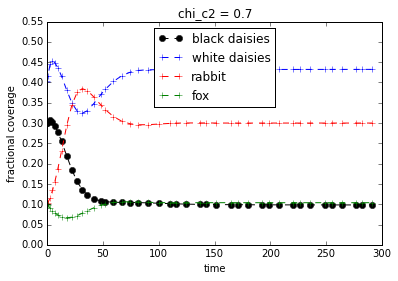

In [45]:
from IPython.display import Image
Image(filename='newfox/chi_c2_7.png') 

③$\chi_{c2} = 0.5$

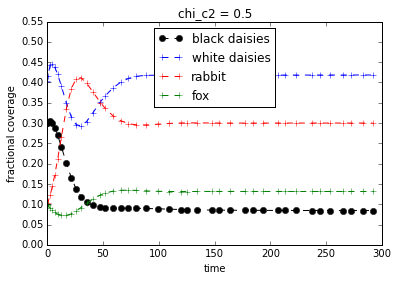

In [46]:
from IPython.display import Image
Image(filename='newfox/chi_c2_5.png') 

Observing the three plots above, we can find that: when $\chi_{c2}$ decreases, The coverage of rabbit will not change. The converages of both kinds of daisy will decrease and that of fox will increase.

Explanation:

When $\chi_{c2}$ decreases, there will less rabbit eaten by per fox. According to $\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0$. Since the death rate of daisy does not change, according to $\frac{dA_i}{dt}=A_i(x\beta_i - \chi_d)=0$, $x$ will not change. Then according to $A_b+A_w + A_f= 1-x- A_r$ and $0=\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r-\chi_r-\chi_{c2}A_f]$, the coverage of daisy must decrease and that of fox must increase.

5)Change $\beta_r$ and keep other parameters unchanged.

①$\beta_r = 0.35$

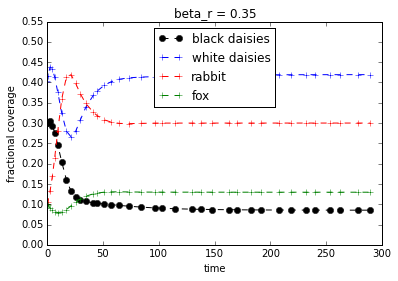

In [47]:
from IPython.display import Image
Image(filename='newfox/beta_r_35.png') 

②$\beta_r = 0.25$

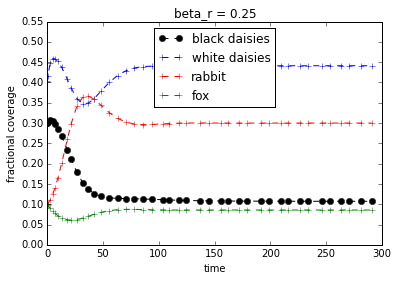

In [48]:
from IPython.display import Image
Image(filename='newfox/beta_r_25.png') 

③$\beta_r = 0.15$

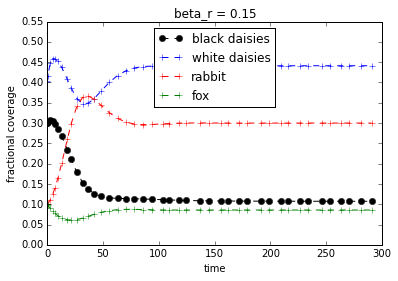

In [49]:
from IPython.display import Image
Image(filename='newfox/beta_r_15.png') 

Observing the three plots above, we can find that: when $\beta_r$ (rabbit's growth rate) decreases, the coverages of rabbit will not change. The coverage of both kinds of daisy will increase and that of fox will decrease.

Explanation:

According to $\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0$, the coverage of rabbit will not change. When rabbit's growth rate($\beta_r$) decreases, to keep the final population of rabbit unchanged, there should be less fox (rabbit's predator). Since the death rate of daisy does not change, according to $\frac{dA_i}{dt}=A_i(x\beta_i - \chi_d)=0$ and $A_b+A_w = 1- A_r- A_f -x$, there will be more daisy.

6)Change $\chi_r$ and keep other parameters unchanged.

①$\chi_r = 0.08$

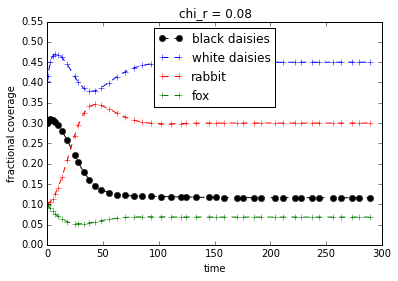

In [50]:
from IPython.display import Image
Image(filename='newfox/chi_r_8.png') 

②$\chi_r = 0.06$

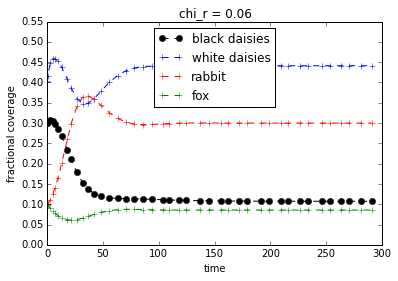

In [51]:
from IPython.display import Image
Image(filename='newfox/chi_r_6.png') 

③$\chi_r = 0.04$

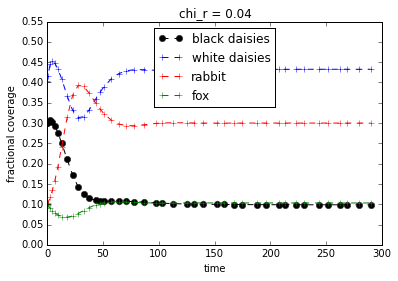

In [52]:
from IPython.display import Image
Image(filename='newfox/chi_r_4.png') 

Observing the three plots above, we can find that: when $\chi_r$ (rabbit's death rate) decreases, the coverages of rabbit will not change. The coverage of both kinds of daisy will decrease and that of fox will increase.

Explanation:

According to $\frac{dA_f}{dt}=A_f(A_r\beta_f - \chi_f) = 0$, the coverage of rabbit will not change. Since the death rate of daisy does not change, according to $\frac{dA_i}{dt}=A_i(x\beta_i - \chi_d)=0$ , $x$ will not change. When rabbit's death rate($\chi_r$) decreases, to keep the final population of rabbit unchanged, according to $0=\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r-\chi_r-\chi_{c2}A_f]$and $A_b+A_w +A_f= 1- A_r- x$, there will be less daisy and more fox.

4 Change L and keep other paremeters unchanged.

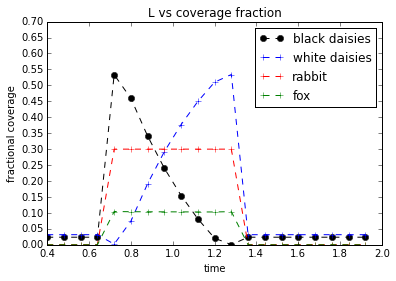

In [53]:
from IPython.display import Image
Image(filename='newfox/varied_L.png') 

 When L is extremely small or big, rabbit and fox can not survive. But there is still small number of daisy. This is because fox and rabbit die out before daisy. Then although daisy's growth rates are zero, their death rates are also zero. So daisy can keep a steady state which does not have to be zero.

Actuall, I think the assumption that the death rate of daisy is propotional to the coverage fraction of rabbit is not reasonable. Because when the coverage of rabbit is zero, the death rate of daisy should not be zero. But the assumption causes the death rate to be zero. Maybe we can assume that $\chi_d = \chi_{c1}A_r + \chi_{c3}$, where $\chi_{c1}$ and $\chi_{c3}$ are constants, instead of $\chi_d = \chi_{c1}A_r$.

When $\chi_{c3}=0.2$, plot the result.

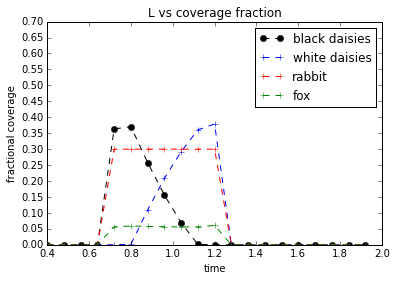

In [55]:
from IPython.display import Image
Image(filename='newfox/correct.png') 

With this assumption, when L is extremely large or small, all creatures will die out, which is reasonable.

II)Assume the brith rate of white daisy and black daisy are constants and are equal.

1.Solve the steady state of equations(assume $\chi_r = \chi_f$).

$$ 0=\frac{dA_i}{dt}=A_i(x\beta_i-\chi_d),i=b,w$$
$$ 0=\frac{dA_r}{dt}=A_r[(A_b+A_w)\beta_r-\chi_r-\chi_{featr}]$$
$$ 0=\frac{dA_f}{dt}=A_f[A_r\beta_f-\chi_f]$$

We get the following solution:
$$ A_r = \frac{\chi_f} {\beta_f}$$
$$A_f = \frac{1-\frac{\chi_{c1}}{\beta_b}\frac{\chi_f}{\beta_f}-\frac{\chi_r}{\beta_r}}{1+\frac{\chi_{c2}}{\beta_r}}$$
$$A_b + A_w = \frac{\chi_{c2}}{\beta_f}\frac{1-\frac{\chi_{c1}}{\beta_b}\frac{\chi_f}{\beta_f}-\frac{\chi_r}{\beta_r}}{1+\frac{\chi_{c2}}{\beta_r}} + \frac{\chi_r}{\beta_r} $$
$$A_b = (A_b + A_w)\frac{A_{b(t=0)}}{A_{b(t=0)}+A_{w(t=0)}}$$
$$A_w = (A_b + A_w)\frac{A_{b(t=0)}}{A_{w(t=0)}+A_{w(t=0)}}$$

2.Use program to find the range of initial conditions that produce this steady state

In [35]:
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class Integnewfox(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rabbitconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc,self.initvars.rabbitconc,self.initvars.foxconc])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [4] with the white [0], black [1], rabbit [2], and fox[3]
                    creature fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1] - yvals[2] - yvals[3]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black + yvals[2] * user.albedo_rabbit + yvals[3] * user.albedo_fox
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.S0 / (4.0 * sigma)
        temp_b = (eta * user.L * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * user.L * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=fraction rabbit
           y[3]=fraction fox
           temperature does not influence growth rates and death rates of both rabbit and fox
        """
        user = self.uservars
        bare = 1.0 - y[0] - y[1] - y[2] - y[3]
        # create a 1 x 4 element vector to hold the derivitive
        f = np.empty_like(y)
        if y[2]<0:
            y[2]=0
        if y[3]<0:
            y[3]=0
        f[0] = y[0] * (user.beta_w * bare - y[2] * user.chi_c1)
        f[1] = y[1] * (user.beta_b * bare - y[2] * user.chi_c1)
        f[2] = y[2]*((y[0] + y[1]) * user.beta_r - y[3] * user.chi_c2 - user.chi_r)
        f[3] = y[3] * (y[2] * user.beta_f - user.chi_f)
        return f

Parameters:
$$ \alpha_w = 0.75 $$
$$ S0=3668.0 $$
$$ L=1.1 $$
$$ \alpha_b=0.25 $$
$$ R=0.12 $$
$$ \sigma=5.67e-08 $$
$$ \alpha_g = 0.5$$
$$ \alpha_r = 0.5$$
$$ \alpha_f = 0.5$$
$$ \chi_{c1}= 0.2 $$
$$ \chi_{c2}= 0.9 $$
$$ \chi_f = 0.06 $$
$$ \chi_r = 0.06 $$
$$ \beta_f = 0.2 $$
$$ \beta_r = 0.25 $$
$$ \beta_b = 0.4 $$
$$ \beta_w = 0.4 $$

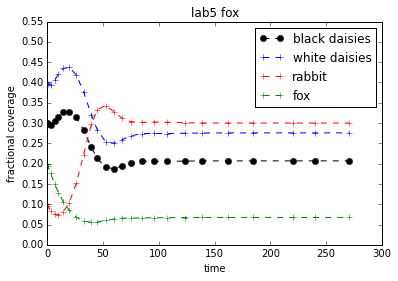

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

theSolver=Integnewfox('newfox2.yaml')
timeVals,yVals,errorList=theSolver.timeloop5Err()

yvals=pd.DataFrame.from_records(yVals,columns=['white','black','rabbit','fox'])

thefig,theAx=plt.subplots(1,1)


theLine1,=theAx.plot(timeVals,yvals['black'],'--ko',label='black daisies')
theLine2,=theAx.plot(timeVals,yvals['white'],'--b+',label='white daisies')
theLine3,=theAx.plot(timeVals,yvals['rabbit'],'--r+',label='rabbit')
theLine4,=theAx.plot(timeVals,yvals['fox'],'--g+',label='fox')
theAx.set_title('lab5 fox')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
theAx.set_yticks(np.linspace(0,0.55,12))
out=out=theAx.legend(loc='best')

For initial conditions:
whiteconc = 0.4, blackconc = 0.3, rabbitconc = 0.1, foxconc = 0.1

1)Change white daisy's initial coverage and keep others unchanged. 

It turns out that when whiteconc varies from 0 to 0.5, the final steady of rabbit and fox will not change. Because the steady state of two kinds of daisy is decided by their initial coverage, they will change. In conclusion, white daisy's concentration can vary betwee 0 and 0.5.

2)Change black daisy's initial coverage and keep others unchanged.

Similarly, when blackconc varies from 0 to 0.4, the final steady of rabbit and fox will not change.

3)Change rabbit's initial coverage and keep others unchanged.

When rabbitconc varies from 0 to 0.2, the final steady of rabbit and fox will not change, except when rabbitconc = 0.

4)Change fox's initial coverage and keep others unchanged.

Similarly, when foxconc varies from 0 to 0.2, the final steady of rabbit and fox will not change, except when foxconc = 0.

3.Use analytic expression to find the range of death/birth coefficients that yeilds a steady state where one or both of rabbits and foxes are not extinct.

Because I assume the birth rate coeffient of fox is the fraction coverage of rabbit, the birth rate coefficient of rabbit is the fraction coverage of fox, and the birth rate coefficient of daisy is $x$, I will talk about the range of death coefficients, $\chi_{c1}$ and $\chi_{c2}$. 

Acoording to the following expressions:
$$ A_r = \frac{\chi_f} {\beta_f}$$
$$A_f = \frac{1-\frac{\chi_{c1}}{\beta_b}\frac{\chi_f}{\beta_f}-\frac{\chi_r}{\beta_r}-\frac{\chi_f}{\beta_f}}{1+\frac{\chi_{c2}}{\beta_r}}$$
$$A_b + A_w = \frac{\chi_{c2}}{\beta_f}\frac{1-\frac{\chi_{c1}}{\beta_b}\frac{\chi_f}{\beta_f}-\frac{\chi_r}{\beta_r}-\frac{\chi_f}{\beta_f}}{1+\frac{\chi_{c2}}{\beta_r}} + \frac{\chi_r}{\beta_r} $$
$$A_b = (A_b + A_w)\frac{A_{b(t=0)}}{A_{b(t=0)}+A_{w(t=0)}}$$
$$A_w = (A_b + A_w)\frac{A_{b(t=0)}}{A_{w(t=0)}+A_{w(t=0)}}$$

Rabbit will not be extinct,except when $\chi_f = 0$, that is, the death rate of fox is zero. Because the death rate of fox is impossible to be zero, I will only need to talk about when fox will not be extinct. That is, $A_f > 0$.

To ensure  $A_f > 0$, 
$$1-\frac{\chi_{c1}}{\beta_b}\frac{\chi_f}{\beta_f}-\frac{\chi_r}{\beta_r}-\frac{\chi_f}{\beta_f}>0$$

This leads to:
$$\chi_{c1}<(1-\frac{\chi_r}{\beta_r}-\frac{\chi_f}{\beta_f})\frac{\beta_f}{\chi_f}\beta_b$$